In [2]:
import pandas as pd
import numpy as np
from matplotlib.pylab import plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.model_selection import RepeatedStratifiedKFold


C:\Users\lmh23\AppData\Local\Temp\ipykernel_17216\3688363605.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Load the data
train_data = pd.read_csv('./Dataset/train.csv')
test_data = pd.read_csv('./Dataset/test.csv')

# train_data.head()

Random_Seed = 213

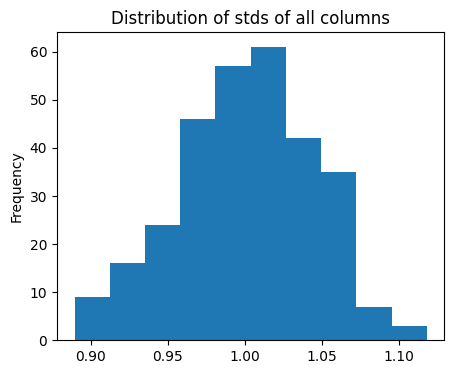

0.8894156662695022
1.1178975848155974
1.0012865965897513


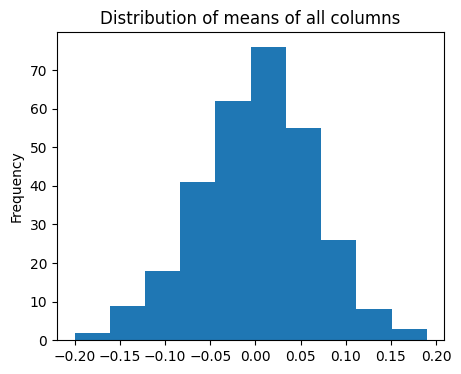

-0.20006400000000002
0.189628
-0.0006210666666666663


In [4]:
train_data[train_data.columns[2:]].std().plot(kind='hist', figsize=(5, 4))
plt.title('Distribution of stds of all columns')
plt.show()
# analyze the distribution of the stds of all columns
print(train_data[train_data.columns[2:]].std().min())
print(train_data[train_data.columns[2:]].std().max())
print(train_data[train_data.columns[2:]].std().mean())



train_data[train_data.columns[2:]].mean().plot(kind='hist', figsize=(5, 4))
plt.title('Distribution of means of all columns')
plt.show()
print(train_data[train_data.columns[2:]].mean().min())
print(train_data[train_data.columns[2:]].mean().max())
print(train_data[train_data.columns[2:]].mean().mean())


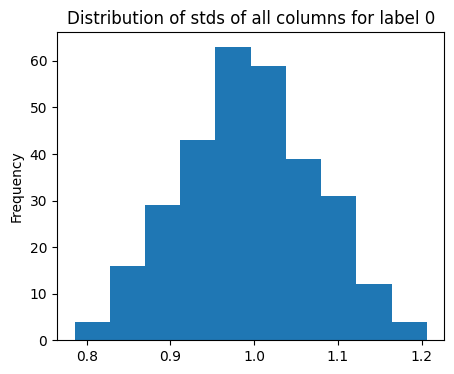

In [5]:
# for label 0
train_data[train_data['target'] == 0][train_data.columns[2:]].std().plot(kind='hist', figsize=(5, 4))
plt.title('Distribution of stds of all columns for label 0')
plt.show()

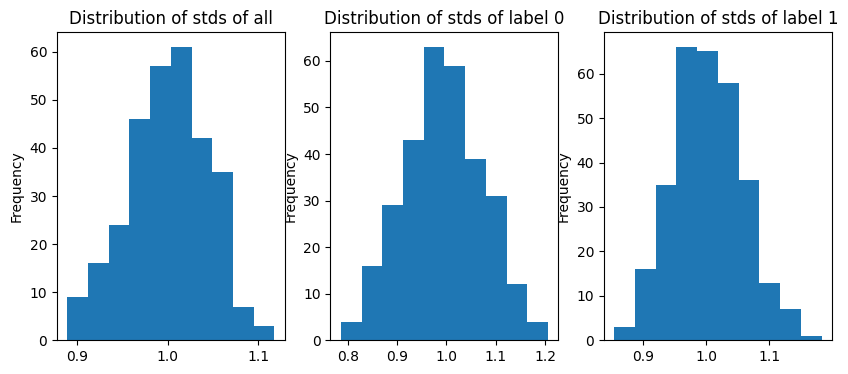

In [11]:
plt.figure(figsize=(10, 4))
# let 3 std plt as 1 plt
plt.subplot(1, 3, 1)
train_data[train_data.columns[2:]].std().plot(kind='hist')
plt.title('Distribution of stds of all')

plt.subplot(1, 3, 2)
train_data[train_data['target'] == 0][train_data.columns[2:]].std().plot(kind='hist')
plt.title('Distribution of stds of label 0')

plt.subplot(1, 3, 3)
train_data[train_data['target'] == 1][train_data.columns[2:]].std().plot(kind='hist')
plt.title('Distribution of stds of label 1')

plt.show()



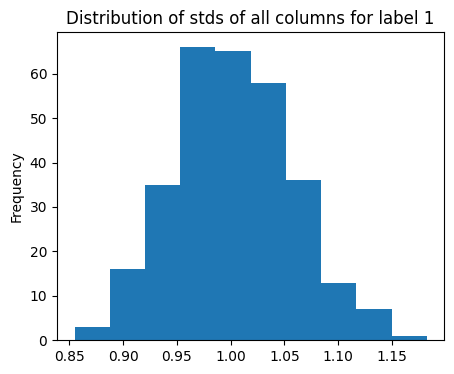

In [6]:
# for label 1
train_data[train_data['target'] == 1][train_data.columns[2:]].std().plot(kind='hist', figsize=(5, 4))
plt.title('Distribution of stds of all columns for label 1')
plt.show()

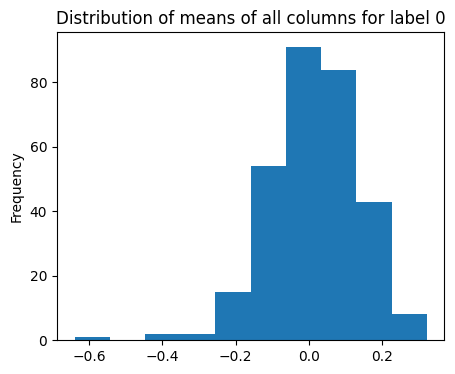

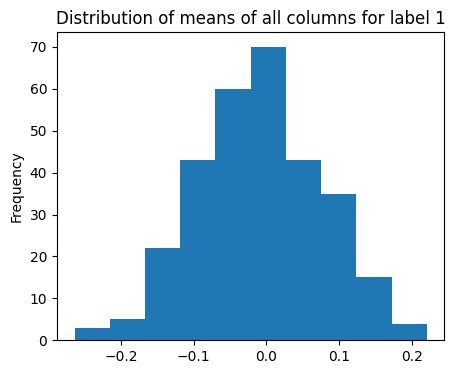

In [21]:
# for label 0
train_data[train_data['target'] == 0][train_data.columns[2:]].mean().plot(kind='hist', figsize=(5, 4))
plt.title('Distribution of means of all columns for label 0')
plt.show()

# for label 1
train_data[train_data['target'] == 1][train_data.columns[2:]].mean().plot(kind='hist', figsize=(5, 4))
plt.title('Distribution of means of all columns for label 1')
plt.show()

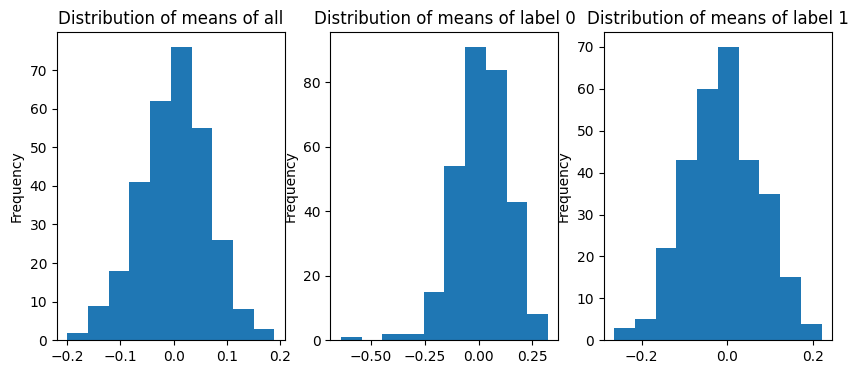

In [22]:
plt.figure(figsize=(10, 4))
# let 3 mean plt as 1 plt
plt.subplot(1, 3, 1)
train_data[train_data.columns[2:]].mean().plot(kind='hist')
plt.title('Distribution of means of all')

plt.subplot(1, 3, 2)
train_data[train_data['target'] == 0][train_data.columns[2:]].mean().plot(kind='hist')
plt.title('Distribution of means of label 0')

plt.subplot(1, 3, 3)
train_data[train_data['target'] == 1][train_data.columns[2:]].mean().plot(kind='hist')
plt.title('Distribution of means of label 1')

plt.show()

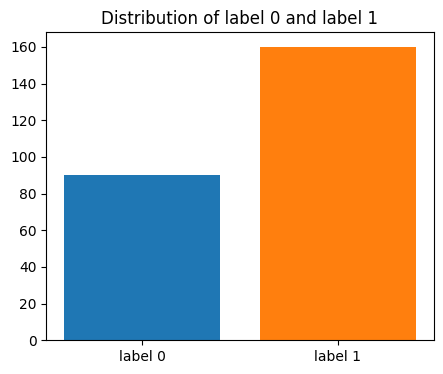

In [23]:
train_data['target'].value_counts()
train_data['target'].value_counts(normalize=True)

# draw the distribution of the target
plt.figure(figsize=(5, 4))
plt.title('Distribution of label 0 and label 1')
plt.bar('label 0', train_data['target'].value_counts()[0])
plt.bar('label 1', train_data['target'].value_counts()[1])
plt.show()


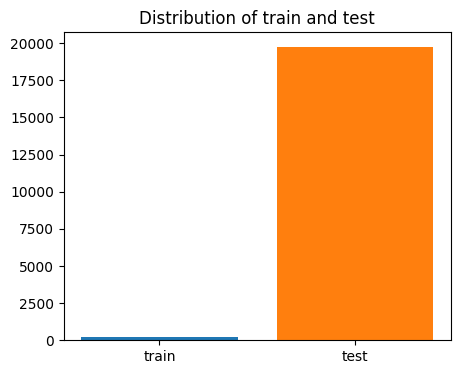

In [24]:
plt.figure(figsize=(5, 4))
plt.title('Distribution of train and test')
plt.bar('train', len(train_data))
plt.bar('test', len(test_data))
plt.show()

Distributions of first 20 columns
[144 162 163 120  38 105  61 123 212   4  72 163 138  69  86 123 297  57]


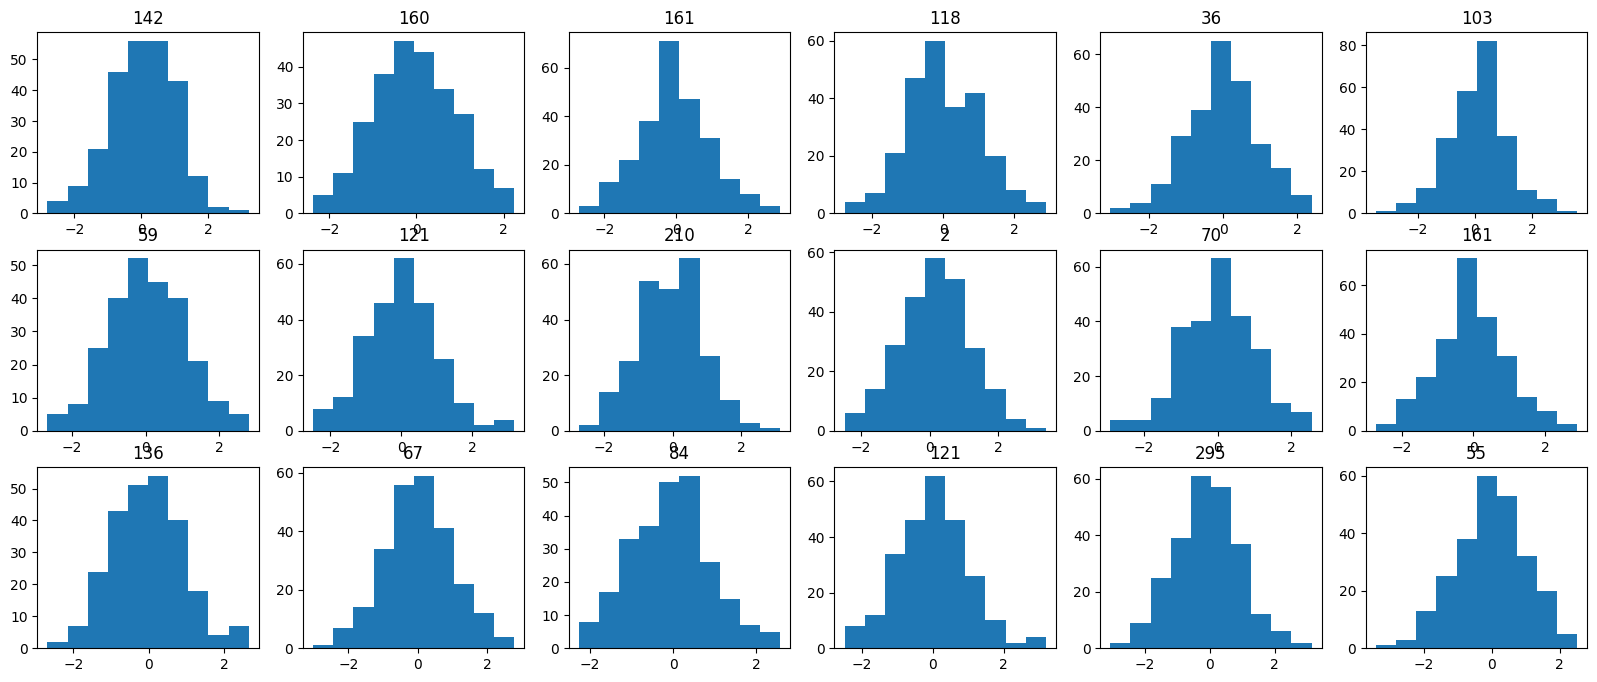

In [25]:
print('Distributions of first 20 columns')
plt.figure(figsize=(20, 8))
# 300随机选取28列数据进行可视化
random_num = np.random.randint(0, 300, 18)
print(random_num)
for i, col in enumerate(train_data.columns[random_num]):
    plt.subplot(3, 6, i + 1)
    plt.hist(train_data[col])
    plt.title(col)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:00<00:00, 535.10it/s]


number of features with diff distribution : 283


<Figure size 2000x1600 with 0 Axes>

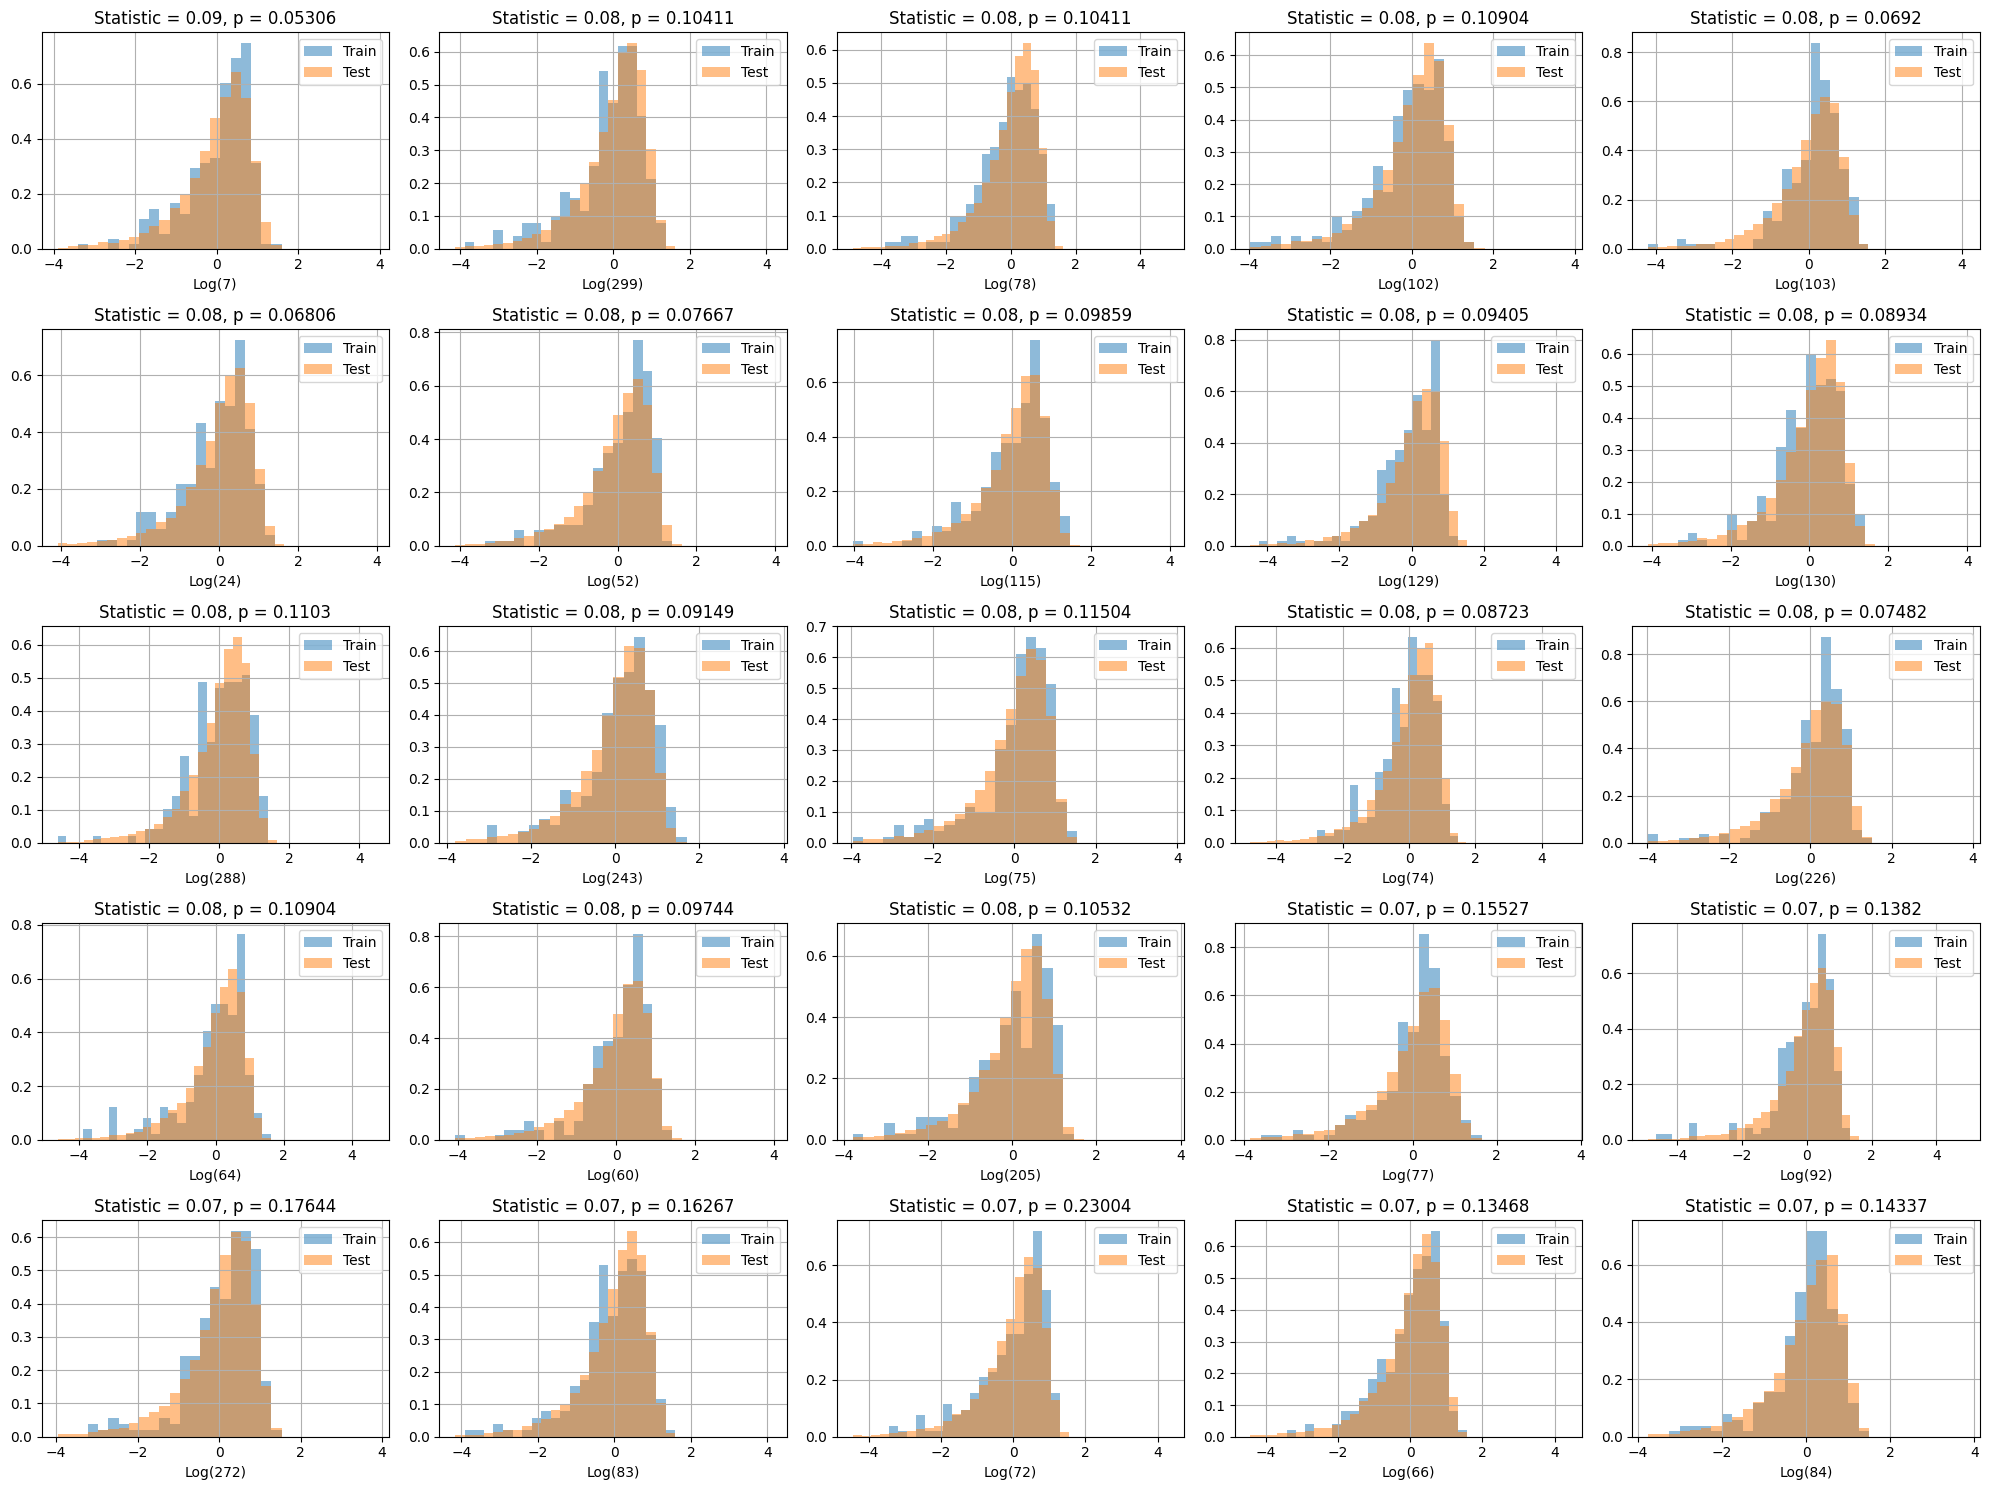

In [26]:
from tqdm import tqdm
from scipy.stats import ks_2samp

def get_diff_columns(train_df, test_df, show_plots=True, show_all=False, threshold=0.1):
    """Use KS to estimate columns where distributions differ a lot from each other"""

    # Find the columns where the distributions are very different
    diff_data = []
    for col in tqdm(train_df.columns):
        statistic, pvalue = ks_2samp(
            train_df[col].values, 
            test_df[col].values
        )
        if pvalue > 0.05 and np.abs(statistic) < threshold:
            diff_data.append({'feature': col, 'p': np.round(pvalue, 5), 'statistic': np.round(np.abs(statistic), 2)})

    # Put the differences into a dataframe
    diff_df = pd.DataFrame(diff_data).sort_values(by='statistic', ascending=False)
    print(f"number of features with diff distribution : {len(diff_df)}")
    if show_plots:
        # Let us see the distributions of these columns to confirm they are indeed different
        n_cols = 5
        n_rows = 5
        _, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))
        axes = [x for l in axes for x in l]

        # Create plots
        for i, (_, row) in enumerate(diff_df.iterrows()):
            if i >= len(axes):
                break
            extreme = np.max(np.abs(train_df[row.feature].tolist() + test_df[row.feature].tolist()))
            train_df.loc[:, row.feature].apply(np.log1p).hist(
                ax=axes[i], alpha=0.5, label='Train', density=True,
                bins=np.arange(-extreme, extreme, 0.25)
            )
            test_df.loc[:, row.feature].apply(np.log1p).hist(
                ax=axes[i], alpha=0.5, label='Test', density=True,
                bins=np.arange(-extreme, extreme, 0.25)
            )
            axes[i].set_title(f"Statistic = {row.statistic}, p = {row.p}")
            axes[i].set_xlabel(f'Log({row.feature})')
            axes[i].legend()

        plt.tight_layout()
        plt.show()
        
    return diff_df
plt.figure(figsize=(20, 16))
# Get the columns which differ a lot between test and train
diff_df = get_diff_columns(train_data.drop(['id','target'], axis=1), test_data.drop(['id'], axis=1))


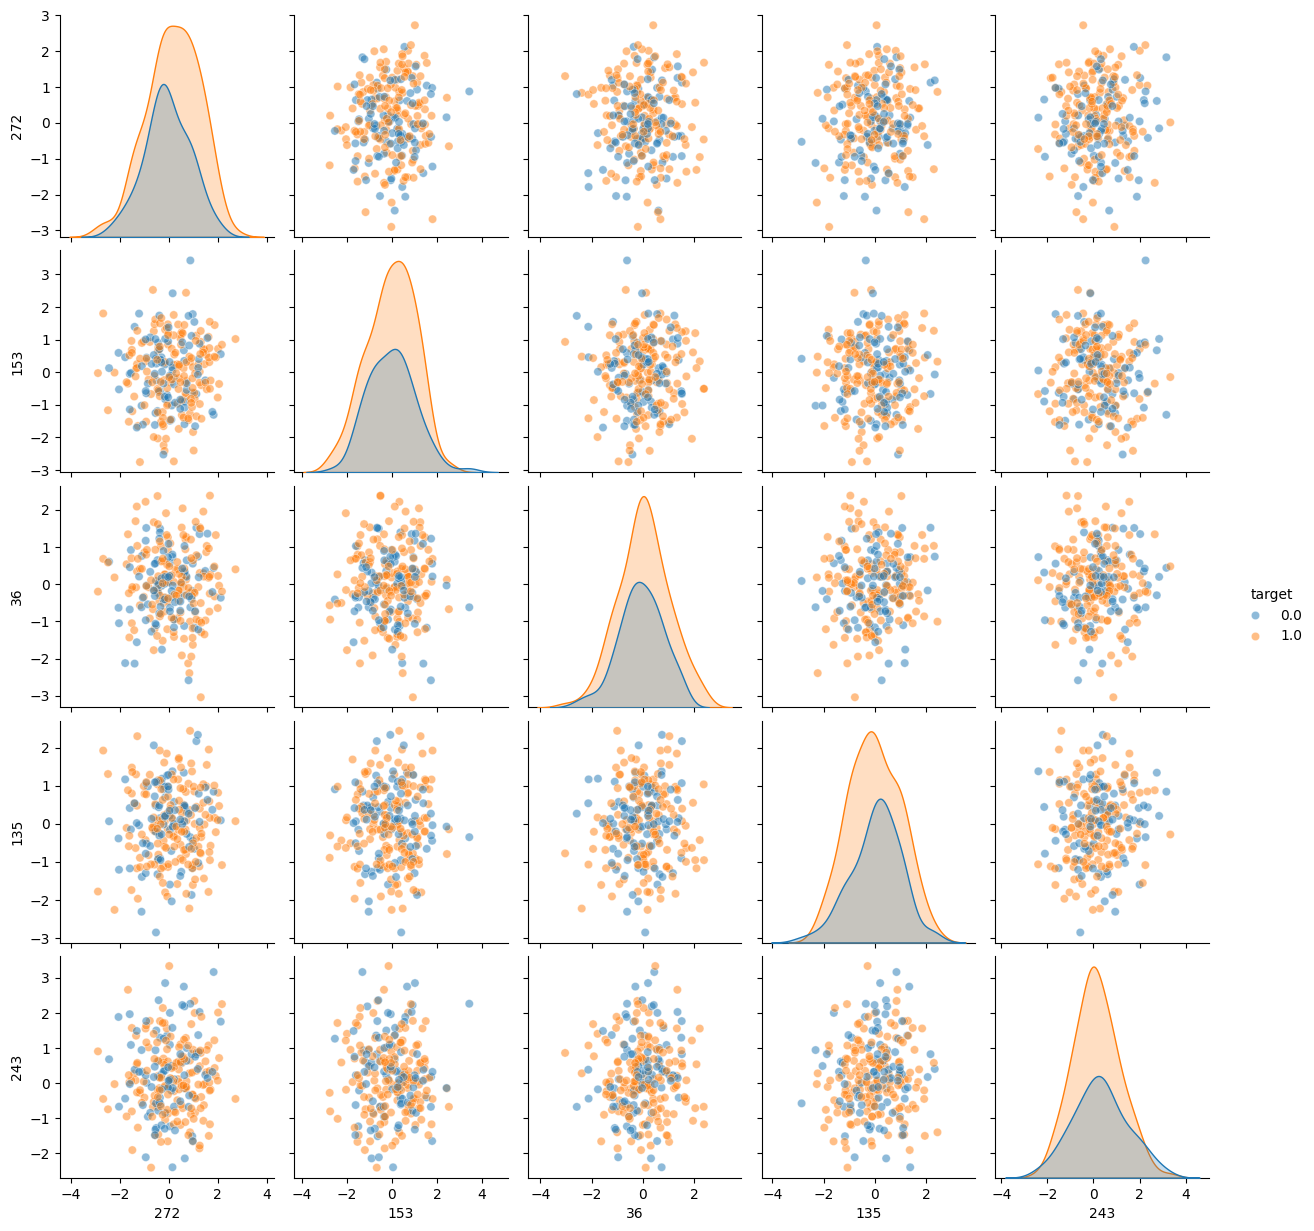

In [27]:
# select random columns to visualize
# sns.set(figsize=(10, 8))
columns = np.random.choice(diff_df.feature, 5)

# 作这五个特征的pairplot
df = train_data[['target'] + list(columns)]
sns.pairplot(df, hue='target', plot_kws={'alpha': 0.5})



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 586.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19750 entries, 0 to 19749
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 45.2 MB
None


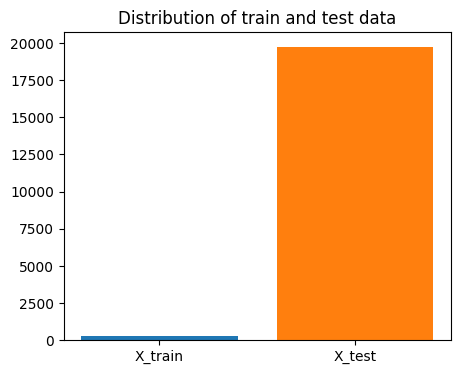

In [28]:
# Manage the data from the train_data
X_train = train_data.drop(['id', 'target'], axis=1)
y_train = train_data['target']

# Manage the data from the test_data
test = test_data.drop(['id'], axis=1)

# Analyze the data
print(X_train.info())
print(test.info())
plt.figure(figsize=(5, 4))
plt.title('Distribution of train and test data')

plt.bar('X_train', X_train.count())
plt.bar('X_test', test.count())
plt.show()


## Basic model

In [29]:
# D tree
# Standardization Scaler
stdScaler = StandardScaler()
X_train_standard = stdScaler.fit_transform(X_train)
test_standard = stdScaler.transform(test)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Create a decision tree classifier
DTC = DecisionTreeClassifier(random_state=Random_Seed, max_depth=5,splitter='best',criterion='gini')

# Train the classifier
scores = cross_val_score(DTC, X_train_standard, y_train, cv=20, scoring='roc_auc')
print(f"Mean ROC AUC: {scores.mean()}")
print(f"Std ROC AUC: {scores.std()}")
print(f"Min ROC AUC: {scores.min()}")
print(f"Max ROC AUC: {scores.max()}")
print(f"ROC AUC values: {scores}")

# use to predict the test data
DTC.fit(X_train_standard, y_train)

# Predict the test data
y_pred = DTC.predict_proba(test_standard)[:, 1]

# Create a submission file
submission = pd.DataFrame({'id': test_data.id, 'target': y_pred})
submission.to_csv('./Submission/DT.csv', index=False)
submission.head()




Mean ROC AUC: 0.5587500000000001
Std ROC AUC: 0.1661477599156847
Min ROC AUC: 0.25
Max ROC AUC: 0.7750000000000001
ROC AUC values: [0.65     0.775    0.3125   0.675    0.775    0.5625   0.775    0.5
 0.6375   0.7      0.34375  0.34375  0.59375  0.734375 0.640625 0.59375
 0.328125 0.421875 0.5625   0.25    ]


,id,target
0,250,0.912281
1,251,0.912281
2,252,0.125000
3,253,0.912281
4,254,0.912281


In [30]:
# knn
# Standardization Scaler
stdScaler = StandardScaler()
X_train_standard = stdScaler.fit_transform(X_train)
test_standard = stdScaler.transform(test)
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN classifier
KNN = KNeighborsClassifier(n_neighbors=170)

# Train the classifier
scores = cross_val_score(KNN, X_train_standard, y_train, cv=20, scoring='roc_auc')
print(f"Mean ROC AUC: {scores.mean()}")


# use to predict the test data
KNN.fit(X_train_standard, y_train)

# Predict the test data
y_pred = KNN.predict_proba(test_standard)[:, 1]

# Create a submission file
submission = pd.DataFrame({'id': test_data.id, 'target': y_pred})
submission.to_csv('./Submission/KNN.csv', index=False)
submission.head()

e:\Anaconda\envs\LMH\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "e:\Anaconda\envs\LMH\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Mean ROC AUC: 0.67453125


,id,target
0,250,0.611765
1,251,0.617647
2,252,0.623529
3,253,0.647059
4,254,0.623529


In [31]:
## Random Forest

# Standardization Scaler
stdScaler = StandardScaler()
X_train_standard = stdScaler.fit_transform(X_train)
test_standard = stdScaler.transform(test)
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
RFC = RandomForestClassifier(n_estimators=400, random_state=Random_Seed, max_depth=10)

# Train the classifier
scores = cross_val_score(RFC, X_train_standard, y_train, cv=20, scoring='roc_auc')
print(f"Mean ROC AUC: {scores.mean()}")


# use to predict the test data
RFC.fit(X_train_standard, y_train)

# Predict the test data
y_pred = RFC.predict_proba(test_standard)[:, 1]

# Create a submission file
submission = pd.DataFrame({'id': test_data.id, 'target': y_pred})
submission.to_csv('./Submission/RFC.csv', index=False)
submission.head()

Mean ROC AUC: 0.7240625


,id,target
0,250,0.592739
1,251,0.600351
2,252,0.616769
3,253,0.727876
4,254,0.665939


In [32]:
# LR
# Standardization Scaler
stdScaler = StandardScaler()
X_train_standard = stdScaler.fit_transform(X_train)
test_standard = stdScaler.transform(test)

LRmodel = LogisticRegression(class_weight="balanced", solver='liblinear', C=0.01, penalty ='l1')
scores = cross_val_score(LRmodel, X_train_standard, y_train, cv=20, scoring='roc_auc')
print(f"Mean ROC AUC: {scores.mean()}")
print(f"Std ROC AUC: {scores.std()}")
print(f"Min ROC AUC: {scores.min()}")
print(f"Max ROC AUC: {scores.max()}")
print(f"ROC AUC values: {scores}")

LRmodel.fit(X_train_standard, y_train)
y_pred = LRmodel.predict_proba(test_standard)[:,1]

# accuracy
y_pred_train = LRmodel.predict(X_train_standard)
print('Accuracy on training set: ', accuracy_score(y_train, y_pred_train))

y_pred

# Write the result to a file
submission = pd.DataFrame({'id': test_data.id, 'target': y_pred})
submission.to_csv('./Submission/LR.csv', index=False)
submission.head()

Mean ROC AUC: 0.5
Std ROC AUC: 0.0
Min ROC AUC: 0.5
Max ROC AUC: 0.5
ROC AUC values: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5]
Accuracy on training set:  0.36


,id,target
0,250,0.5
1,251,0.5
2,252,0.5
3,253,0.5
4,254,0.5


In [33]:
# SVM
from sklearn.svm import SVC

# Standardization Scaler
stdScaler = StandardScaler()
X_train_standard = stdScaler.fit_transform(X_train)
test_standard = stdScaler.transform(test)


SVM = SVC(kernel='linear', C=1000, probability=True)
scores = cross_val_score(SVM, X_train_standard, y_train, cv=20, scoring='roc_auc')
print(f"Mean ROC AUC: {scores.mean()}")

SVM.fit(X_train_standard, y_train)
y_pred = SVM.predict_proba(test_standard)[:, 1]

# Write the result to a file
submission = pd.DataFrame({'id': test_data.id, 'target': y_pred})
submission.to_csv('./Submission/SVM.csv', index=False)
submission.head()

Mean ROC AUC: 0.7793749999999999


,id,target
0,250,0.383861
1,251,0.227385
2,252,0.641587
3,253,0.950855
4,254,0.491848


In [34]:
# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

# Standardization Scaler
stdScaler = StandardScaler()
X_train_standard = stdScaler.fit_transform(X_train)
test_standard = stdScaler.transform(test)

GBC = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, random_state=Random_Seed)
scores = cross_val_score(GBC, X_train_standard, y_train, cv=20, scoring='roc_auc')

print(f"Mean ROC AUC: {scores.mean()}")

GBC.fit(X_train_standard, y_train)
y_pred = GBC.predict_proba(test_standard)[:, 1]

# Write the result to a file
submission = pd.DataFrame({'id': test_data.id, 'target': y_pred})
submission.to_csv('./Submission/GBC.csv', index=False)
submission.head()

Mean ROC AUC: 0.6743750000000001


,id,target
0,250,0.572341
1,251,0.999472
2,252,0.809608
3,253,0.990221
4,254,0.993377


In [35]:
# Lasso
# Standardization Scaler
stdScaler = StandardScaler()
X_train_standard = stdScaler.fit_transform(X_train)
test_standard = stdScaler.transform(test)

# Create a Lasso classifier
lasso = Lasso(alpha=0.041, random_state=Random_Seed)

# Train the classifier
scores = cross_val_score(lasso, X_train_standard, y_train, cv=20, scoring='roc_auc')

print(f"Mean ROC AUC: {scores.mean()}")
print(f"Std ROC AUC: {scores.std()}")
print(f"Min ROC AUC: {scores.min()}")
print(f"Max ROC AUC: {scores.max()}")

lasso.fit(X_train_standard, y_train)
y_pred = lasso.predict(test_standard)

# Write the result to a file
submission = pd.DataFrame({'id': test_data.id, 'target': y_pred})
submission.to_csv('./Submission/Lasso.csv', index=False)
submission.head()

Mean ROC AUC: nan
Std ROC AUC: nan
Min ROC AUC: nan
Max ROC AUC: nan


e:\Anaconda\envs\LMH\lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\Anaconda\envs\LMH\lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
  File "e:\Anaconda\envs\LMH\lib\site-packages\sklearn\metrics\_scorer.py", line 344, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "e:\Anaconda\envs\LMH\lib\site-packages\sklearn\utils\validation.py", line 2106, in _check_response_method
    raise AttributeError(
AttributeError: Lasso has none of the following attributes: decision_function, predict_proba.

  warnings.warn(
e:\Anaconda\envs\LMH\lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceba

,id,target
0,250,0.778033
1,251,0.625401
2,252,0.626712
3,253,0.817703
4,254,0.563561


In [36]:
#XGB
import xgboost as xgb

# Standardization Scaler
stdScaler = StandardScaler()
X_train_standard = stdScaler.fit_transform(X_train)
test_standard = stdScaler.transform(test)

# Create a XGB classifier
XGB = xgb.XGBClassifier(n_estimators=283, learning_rate=0.1, max_depth=3, random_state=Random_Seed)

# Train the classifier
scores = cross_val_score(XGB, X_train_standard, y_train, cv=20, scoring='roc_auc')

print(f"Mean ROC AUC: {scores.mean()}")
# print(f"Std ROC AUC: {scores.std()}")

XGB.fit(X_train_standard, y_train)
y_pred = XGB.predict_proba(test_standard)[:, 1]

# Write the result to a file
submission = pd.DataFrame({'id': test_data.id, 'target': y_pred})
submission.to_csv('./Submission/XGB.csv', index=False)
submission.head()

Mean ROC AUC: 0.7590625


,id,target
0,250,0.877634
1,251,0.625466
2,252,0.452434
3,253,0.995210
4,254,0.917569


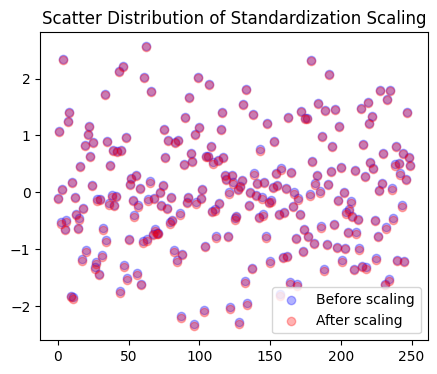

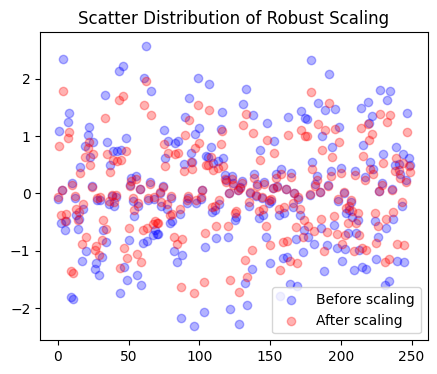

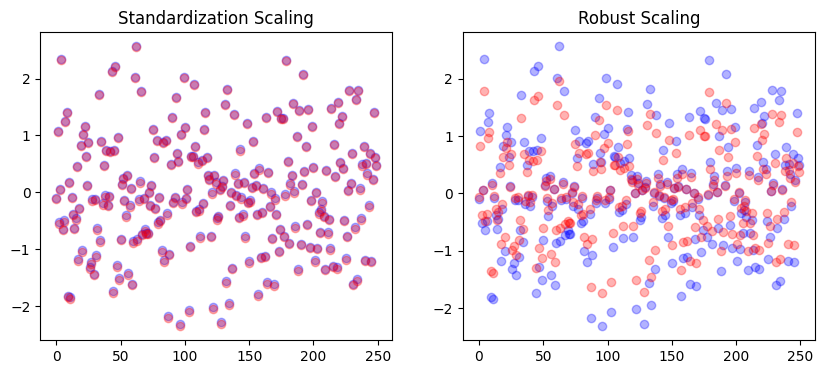

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# 假设数据长度相同，我们需要一个公共的x轴坐标系
x_axis = np.arange(len(X_train['0']))

plt.figure(figsize=(5,4))

# 绘制缩放前的数据，使用蓝色表示
plt.scatter(x_axis, X_train['0'], color='blue', alpha=0.3, label='Before scaling')

# 绘制缩放后的数据，使用红色表示
plt.scatter(x_axis, X_train_standard[:, 0], color='red', alpha=0.3, label='After scaling')

plt.title('Scatter Distribution of Standardization Scaling')
plt.legend()
plt.show()

x_axis = np.arange(len(X_train['0']))

# data before scaling and after scaling
scaler = RobustScaler()
X_train_robust = scaler.fit_transform(X_train)
plt.figure(figsize=(5, 4))
plt.scatter(x_axis, X_train['0'], color='blue', alpha=0.3, label='Before scaling')
plt.scatter(x_axis, X_train_robust[:, 0], color='red', alpha=0.3, label='After scaling')
plt.title('Scatter Distribution of Robust Scaling')
plt.legend()
plt.show()

# combine with two different scaling methods
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(x_axis, X_train['0'], color='blue', alpha=0.3, label='Before scaling')
plt.scatter(x_axis, X_train_standard[:, 0], color='red', alpha=0.3, label='After scaling')
plt.title('Standardization Scaling')


plt.subplot(1, 2, 2)
plt.scatter(x_axis, X_train['0'], color='blue', alpha=0.3, label='Before scaling')
plt.scatter(x_axis, X_train_robust[:, 0], color='red', alpha=0.3, label='After scaling')
plt.title('Robust Scaling')

plt.show()




In [37]:
## adaboost
from sklearn.ensemble import AdaBoostClassifier

# Standardization Scaler
stdScaler = StandardScaler()
X_train_standard = stdScaler.fit_transform(X_train)
test_standard = stdScaler.transform(test)

# Create a AdaBoost classifier
ABC = AdaBoostClassifier(n_estimators=10, learning_rate=0.1, random_state=Random_Seed)

# Train the classifier

scores = cross_val_score(ABC, X_train_standard, y_train, cv=20, scoring='roc_auc')

print(f"Mean ROC AUC: {scores.mean()}")

ABC.fit(X_train_standard, y_train)
y_pred = ABC.predict_proba(test_standard)[:, 1]

# Write the result to a file
submission = pd.DataFrame({'id': test_data.id, 'target': y_pred})
submission.to_csv('./Submission/ABC.csv', index=False)
submission.head()

e:\Anaconda\envs\LMH\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
e:\Anaconda\envs\LMH\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
e:\Anaconda\envs\LMH\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
e:\Anaconda\envs\LMH\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
e:\Anaconda\envs\LMH\lib\sit

Mean ROC AUC: 0.709375


,id,target
0,250,0.662788
1,251,0.696782
2,252,0.520132
3,253,0.742994
4,254,0.687732


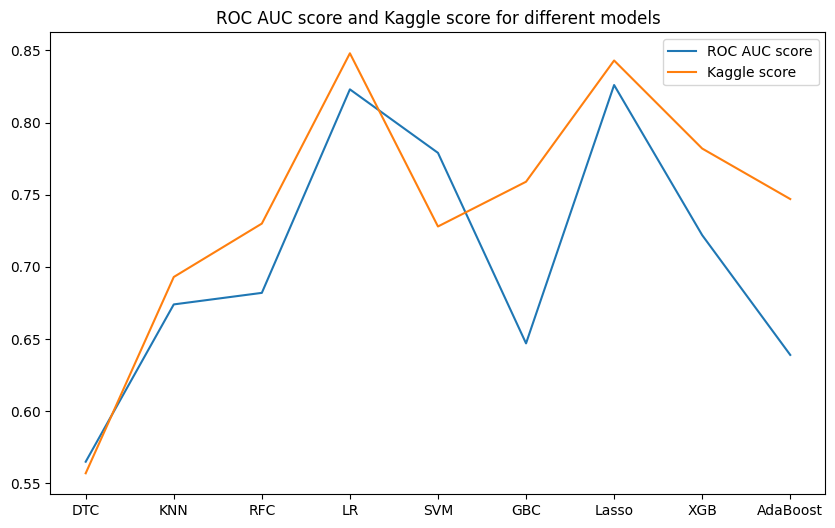

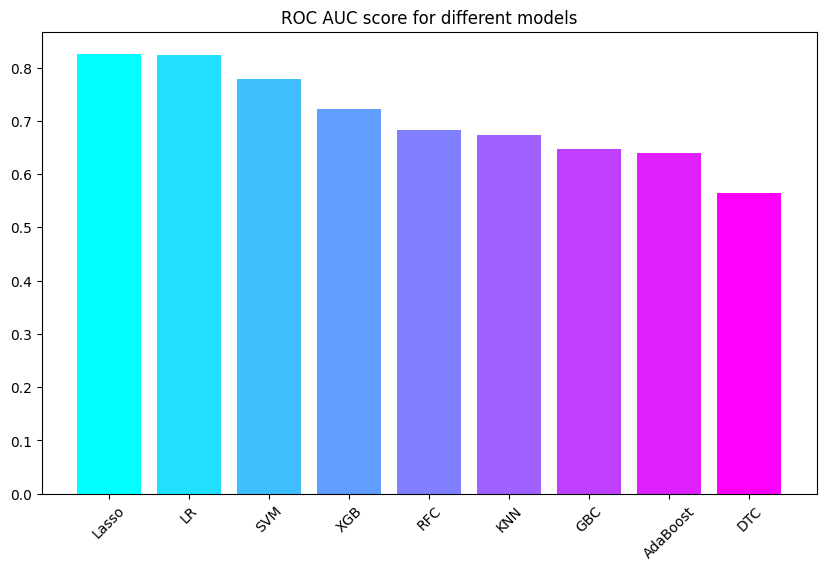

In [80]:
# | Classifier | Kaggle Submission Score | ROC AUC Score |
# |------------|-------------------------|---------------|
# | Decision Tree | 0.557 | 0.565 |
# | KNN | 0.693 | 0.674 |
# | Random Forest | 0.730 | 0.682 |
# | Logistic Regression | 0.848 | 0.823 |
# | SVM | 0.728 | 0.779 |
# | Gradient Boosting | 0.759 | 0.647 |
# | Lasso Regression | 0.843 | 0.826 |
# | XGBoost | 0.782 | 0.722 |
# | AdaBoost | 0.747 | 0.639 |

# put all the models scores together
models = ['DTC', 'KNN', 'RFC', 'LR', 'SVM', 'GBC', 'Lasso', 'XGB', 'AdaBoost']
ROC_AUC_score = [0.565,0.674,0.682,0.823,0.779,0.647,0.826,0.722,0.639]
kaggle_score = [0.557,0.693,0.730,0.848,0.728,0.759,0.843,0.782,0.747]

plt.figure(figsize=(10, 6))
plt.plot(models, ROC_AUC_score, label='ROC AUC score')
plt.plot(models, kaggle_score, label='Kaggle score')
plt.legend()
plt.title('ROC AUC score and Kaggle score for different models')
plt.show()

# bar plot sorted by ROC AUC score, different colors
# zip two lists together
zipped = zip(ROC_AUC_score, models)
# sort by ROC AUC score
zipped = sorted(zipped, key=lambda x: x[0], reverse=True)
# unzip
ROC_AUC_score, models = zip(*zipped)


plt.figure(figsize=(10, 6))
# Create a color gradient for the bars in rainbow colors
colors = plt.cm.cool(np.linspace(0, 1, len(models)))
plt.bar(models, ROC_AUC_score, color=colors)
plt.title('ROC AUC score for different models')
plt.xticks(rotation=45)  # Rotate model names for better visibility
plt.show()


In [39]:
# feature selection
from sklearn.feature_selection import RFE
estimator_base = LogisticRegression(class_weight="balanced", solver='liblinear', C=0.095, penalty ='l1')
selector = RFE(estimator_base, n_features_to_select=283, step=17)
selector = selector.fit(X_train_standard, y_train)

X_train_selected = selector.transform(X_train_standard)
# print(X_train_selected.shape, X_train_standard.shape)
test_selected = selector.transform(test_standard)

estimator_base.fit(X_train_selected, y_train)
y_base_pred = estimator_base.predict_proba(test_selected)[:,1]

submission = pd.DataFrame({'id': test_data.id, 'target': y_base_pred})
submission.to_csv('./Submission/LR_Base_RFE.csv', index=False)

y_base_pred

# Roc Auc score
from sklearn.metrics import roc_auc_score
RFE_score_1 = roc_auc_score(y_train, estimator_base.predict_proba(X_train_selected)[:,1])




[0.67678955 0.4761505  0.52459255 ... 0.30719584 0.77823716 0.25288938]
ROC AUC score: 0.9514583333333333


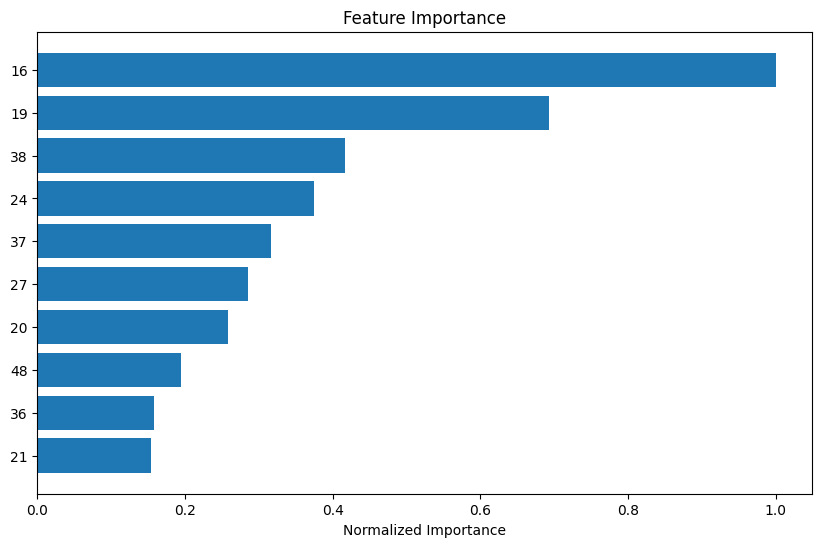

In [62]:
# Assuming X_train, y_train, and test_data are predefined and preprocessed accordingly
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
test_standard = scaler.transform(test_data.drop(columns=['id']))

# Define the estimator and selector
estimator_base = LogisticRegression(class_weight="balanced", solver='liblinear', C=0.095, penalty='l1', random_state=42)
selector = RFE(estimator=estimator_base, n_features_to_select=50, step=0.1)

# Fit the selector
selector.fit(X_train_standard, y_train)

# Transform the datasets based on the selected features
X_train_selected = selector.transform(X_train_standard)
test_selected = selector.transform(test_standard)

# Re-fit the estimator on the selected features
estimator_base.fit(X_train_selected, y_train)

# Generate predictions
y_base_pred = estimator_base.predict_proba(test_selected)[:, 1]

# Prepare and save the submission file
submission = pd.DataFrame({'id': test_data['id'], 'target': y_base_pred})
submission.to_csv('./Submission/LR_Base_RFE_Optimized.csv', index=False)

# Output predictions
print(y_base_pred)

# Calculate the ROC AUC score
from sklearn.metrics import roc_auc_score
RFE_score_2 = roc_auc_score(y_train, estimator_base.predict_proba(X_train_selected)[:, 1])
print(f"ROC AUC score: {RFE_score_2}")

# Figure 9: Normalized importance of the features
# Get the feature importance
importance = selector.estimator_.coef_[0]
importance = np.abs(importance)

# Normalize the importance
importance = importance / np.max(importance)

# Sort the importance
sorted_idx = np.argsort(importance)

# use top 10 features
sorted_idx = sorted_idx[-10:]

# Plot the importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
plt.xlabel('Normalized Importance')
plt.title('Feature Importance')
plt.show()




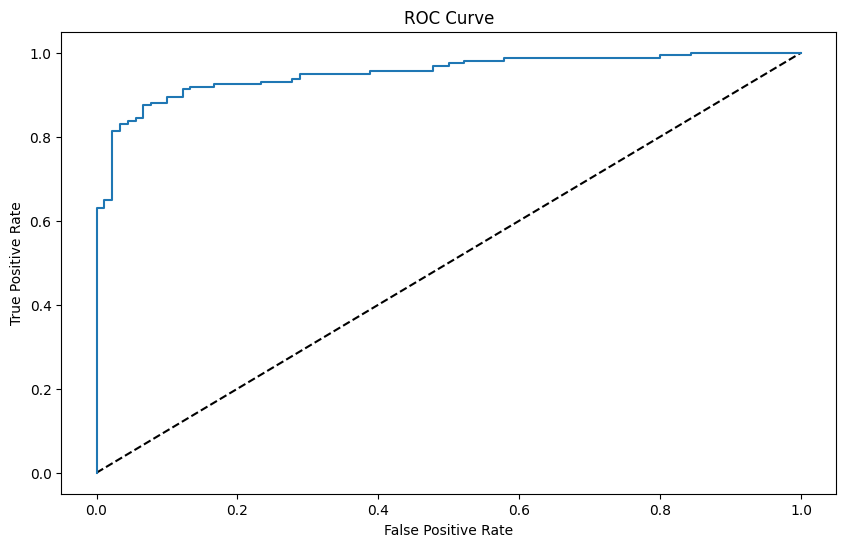

In [63]:
# draw the ROC AUC curve

from sklearn.metrics import roc_curve

# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_train, estimator_base.predict_proba(X_train_selected)[:,1])

plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

AUC: 0.9514583333333333


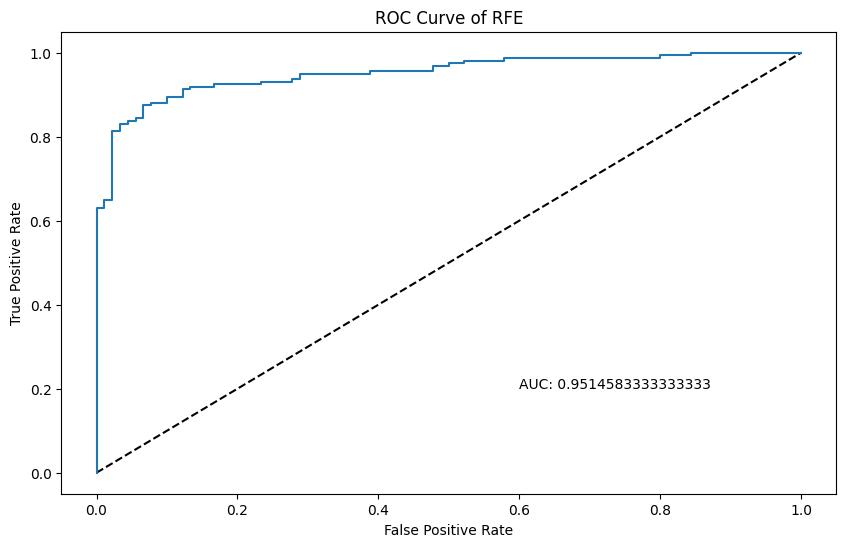

In [64]:
# calculate the AUC
from sklearn.metrics import auc
AUC = auc(fpr, tpr)
print(f"AUC: {AUC}")
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of RFE')
plt.text(0.6, 0.2, f'AUC: {AUC}')
plt.show()

[0.68133455 0.47953857 0.53327792 ... 0.30218641 0.78972884 0.24786588]
ROC AUC score: 0.9569444444444444


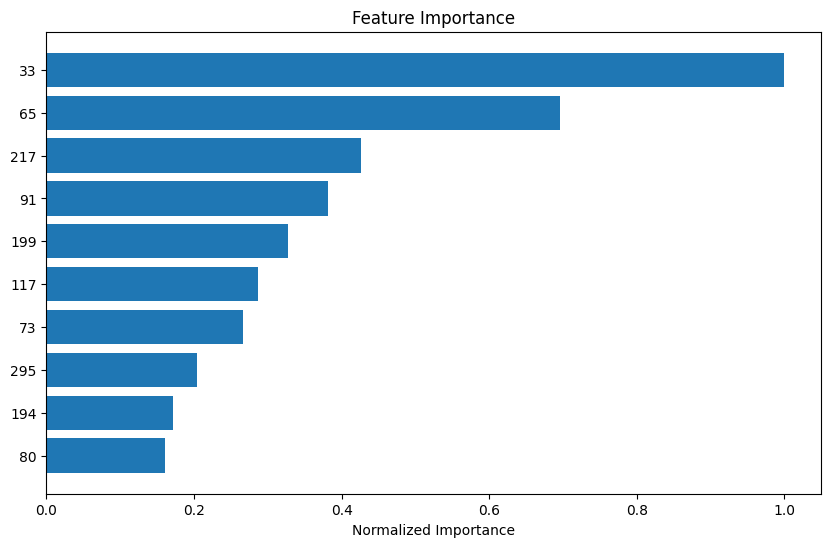

In [56]:
# SelectFromModel
from sklearn.feature_selection import SelectFromModel

# Define the estimator and selector
estimator_base = LogisticRegression(class_weight="balanced", solver='liblinear', C=0.1, penalty='l1', random_state=Random_Seed)

selector = SelectFromModel(estimator=estimator_base, max_features=283, threshold=-np.inf)

# Fit the selector
selector.fit(X_train_standard, y_train)

# Transform the datasets based on the selected features
X_train_selected = selector.transform(X_train_standard)
test_selected = selector.transform(test_standard)

# Re-fit the estimator on the selected features
estimator_base.fit(X_train_selected, y_train)

# Generate predictions
y_base_pred = estimator_base.predict_proba(test_selected)[:, 1]

# Prepare and save the submission file
submission = pd.DataFrame({'id': test_data['id'], 'target': y_base_pred})
submission.to_csv('./Submission/LR_Base_SelectFromModel_Optimized.csv', index=False)

# Output predictions
print(y_base_pred)

# Calculate the ROC AUC score
from sklearn.metrics import roc_auc_score
SelectFromModel_score = roc_auc_score(y_train, estimator_base.predict_proba(X_train_selected)[:, 1])
print(f"ROC AUC score: {SelectFromModel_score}")


importance = selector.estimator_.coef_[0]
importance = np.abs(importance)

# Normalize the importance
importance = importance / np.max(importance)

# Sort the importance
sorted_idx = np.argsort(importance)

# use top 10 features
sorted_idx = sorted_idx[-10:]

# Plot the importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
plt.xlabel('Normalized Importance')
plt.title('Feature Importance')
plt.show()


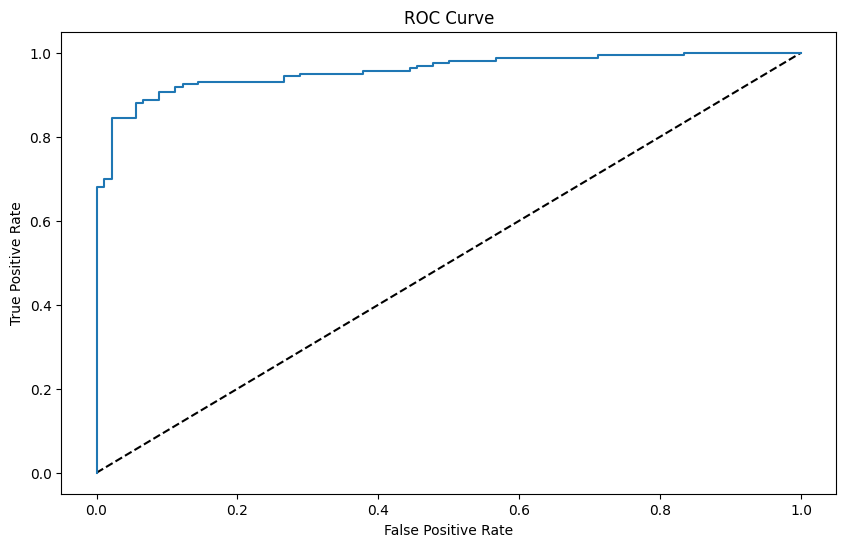

AUC: 0.9569444444444444


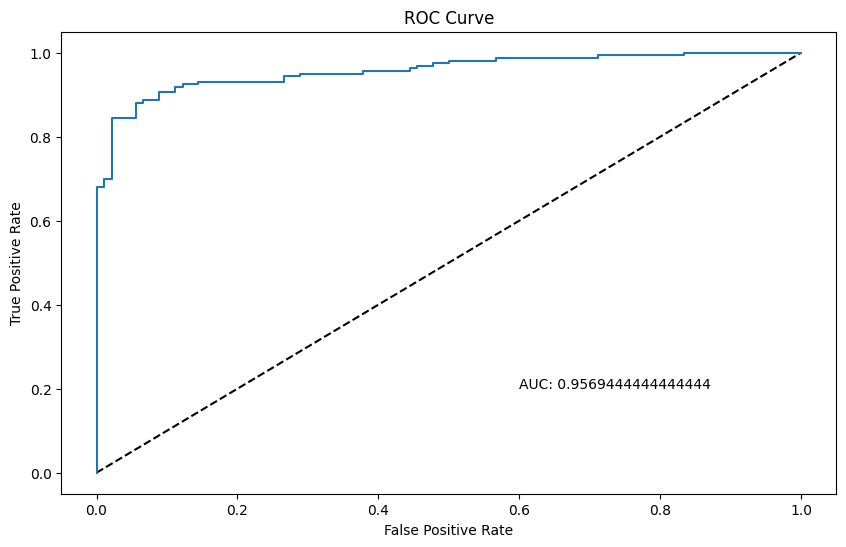

In [57]:
# calculate the AUC

from sklearn.metrics import roc_curve

# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_train, estimator_base.predict_proba(X_train_selected)[:,1])

plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
from sklearn.metrics import auc
AUC = auc(fpr, tpr)
print(f"AUC: {AUC}")
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of SelectFromModel')
plt.text(0.6, 0.2, f'AUC: {AUC}')
plt.show()

In [58]:
# logistic regression with SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Standardization Scaler
stdScaler = StandardScaler()
X_train_standard = stdScaler.fit_transform(X_train)
test_standard = stdScaler.transform(test)

# Create a SMOTE object
smote = SMOTE(random_state=Random_Seed)

# Create a Logistic Regression classifier
LRmodel = LogisticRegression(class_weight="balanced", solver='liblinear', C=0.095, penalty ='l1')

# Create a pipeline
pipeline = Pipeline([('SMOTE', smote), ('LR', LRmodel)])

# Train the classifier
scores = cross_val_score(pipeline, X_train_standard, y_train, cv=20, scoring='roc_auc')

print(f"Mean ROC AUC: {scores.mean()}")

pipeline.fit(X_train_standard, y_train)
y_pred = pipeline.predict_proba(test_standard)[:,1]

# Write the result to a file
submission = pd.DataFrame({'id': test_data.id, 'target': y_pred})
submission.to_csv('./Submission/LR_SMOTE.csv', index=False)
submission.head()

Mean ROC AUC: 0.8081250000000001


,id,target
0,250,0.751748
1,251,0.501619
2,252,0.524666
3,253,0.819791
4,254,0.534213


In [66]:
# some heuristic settings
rfe_min_features = 12
rfe_step = 12
rfe_cv = 25
sss_n_splits = 16
sss_test_size = 0.35
grid_search_cv = 25
noise_std = 0.01
r2_threshold = 0.185

np.random.seed(Random_Seed)

# Manage the data from the train_data
X_train = train_data.drop(['id', 'target'], axis=1)
y_train = train_data['target']

# Manage the data from the test_data
test = test_data.drop(['id'], axis=1)

# scale using RobustScaler
data = RobustScaler().fit_transform(np.concatenate((X_train, test), axis=0))
X_train = data[:250]
test = data[250:]

# add a bit of noise to train_X to reduce overfitting
X_train += np.random.normal(0, noise_std, X_train.shape)

# define roc_auc_metric robust to only one class in y_pred
def scoring_roc_auc(y, y_pred):
    try:
        return roc_auc_score(y, y_pred)
    except:
        return 0.5

robust_roc_auc = make_scorer(scoring_roc_auc)

# define model and its parameters
lasso_model = Lasso(alpha=0.031, random_state=Random_Seed, tol=0.01, selection='random')

param_grid = {
            'alpha' : [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031],
            'tol'   : [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]
        }

# define recursive elimination feature selector
feature_selector = RFECV(lasso_model, min_features_to_select=rfe_min_features, scoring=robust_roc_auc, step=rfe_step, verbose=0, cv=rfe_cv, n_jobs=-1)

print("counter | val_mse  |  val_mae  |  val_roc  |  val_cos  |  val_dist  |  val_r2    | feature_count ")
print("-------------------------------------------------------------------------------------------------")

predictions = pd.DataFrame()
counter = 0
plt_list = []
val_r2_list = []
feature_selector_list = []
# split training data to build one model on each traing-data-subset
for train_index, val_index in StratifiedShuffleSplit(n_splits=sss_n_splits, test_size=sss_test_size, random_state=Random_Seed).split(X_train, y_train):
    X, val_X = X_train[train_index], X_train[val_index]
    y, val_y = y_train[train_index], y_train[val_index]

    # get the best features for this data set
    feature_selector.fit(X, y)
    # remove irrelevant features from X, val_X and test
    X_important_features        = feature_selector.transform(X)
    val_X_important_features    = feature_selector.transform(val_X)
    test_important_features     = feature_selector.transform(test)

    # run grid search to find the best Lasso parameters for this subset of training data and subset of features 
    grid_search = GridSearchCV(feature_selector.estimator_, param_grid=param_grid, verbose=0, n_jobs=-1, scoring=robust_roc_auc, cv=20)
    grid_search.fit(X_important_features, y)

    # score our fitted model on validation data
    val_y_pred = grid_search.best_estimator_.predict(val_X_important_features)
    val_mse = mean_squared_error(val_y, val_y_pred)
    val_mae = mean_absolute_error(val_y, val_y_pred)
    val_roc = roc_auc_score(val_y, val_y_pred)
    val_cos = cosine_similarity(val_y.values.reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_dst = euclidean_distances(val_y.values.reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_r2  = r2_score(val_y, val_y_pred)

    plt_list.append([val_mse, val_mae, val_roc, val_cos, val_dst, val_r2])

    val_r2_list.append(val_r2)
    # count how many features we have
    feature_selector_list.append(feature_selector.n_features_)

    # if model did well on validation, save its prediction on test data, using only important features
    # r2_threshold (0.185) is a heuristic threshold for r2 error
    # you can use any other metric/metric combination that works for you
    if val_r2 > r2_threshold:
        message = '<-- OK'
        prediction = grid_search.best_estimator_.predict(test_important_features)
        predictions = pd.concat([predictions, pd.DataFrame(prediction)], axis=1)
    else:
        message = '<-- skipping'


    print("{0:2}      | {1:.4f}   |  {2:.4f}   |  {3:.4f}   |  {4:.4f}   |  {5:.4f}    |  {6:.4f}    |  {7:3}         {8}  ".format(counter, val_mse, val_mae, val_roc, val_cos, val_dst, val_r2, feature_selector.n_features_, message))
    
    counter += 1

print("-------------------------------------------------------------------------------------------------")
print("{}/{} models passed validation threshold and will be ensembled.".format(len(predictions.columns), sss_n_splits))




mean_pred = pd.DataFrame(predictions.mean(axis=1))
mean_pred.index += 250
mean_pred.columns = ['target']

mean_pred.to_csv('./Submission/Lasso_REFCV.csv', index=True, index_label='id')

print(mean_pred.head())





counter | val_mse  |  val_mae  |  val_roc  |  val_cos  |  val_dist  |  val_r2    | feature_count 
-------------------------------------------------------------------------------------------------
 0      | 0.1962   |  0.3931   |  0.7852   |  0.8341   |  4.1553    |  0.1521    |   12         <-- skipping  
 1      | 0.1877   |  0.3831   |  0.7651   |  0.8400   |  4.0638    |  0.1890    |  240         <-- OK  
 2      | 0.1914   |  0.3783   |  0.7651   |  0.8391   |  4.1045    |  0.1727    |   12         <-- skipping  
 3      | 0.1700   |  0.3712   |  0.8404   |  0.8561   |  3.8681    |  0.2653    |  240         <-- OK  
 4      | 0.1943   |  0.3667   |  0.7606   |  0.8385   |  4.1346    |  0.1605    |   24         <-- skipping  
 5      | 0.1668   |  0.3464   |  0.8147   |  0.8591   |  3.8308    |  0.2794    |   12         <-- OK  
 6      | 0.2159   |  0.3898   |  0.6702   |  0.8152   |  4.3590    |  0.0669    |   48         <-- skipping  
 7      | 0.1712   |  0.3697   |  0.8147   | 

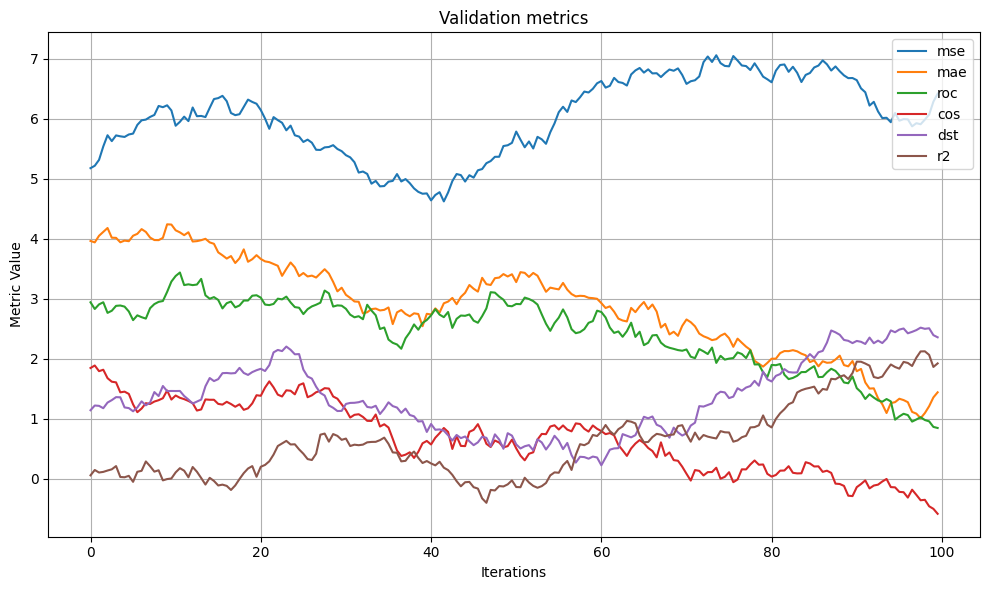

In [68]:
# Let's first create a similar plot in code to understand the structure and then we can improve it.

import matplotlib.pyplot as plt
import numpy as np

# I'm going to assume plt_list contains lists of different metrics.
# Since we don't have the actual data, I will create some sample data to simulate the scenario.

# Generating sample data for 6 different metrics with a smooth curve for demonstration
np.random.seed(0)
x = np.arange(0, 100, 0.5)
metrics = {
    'mse': np.random.normal(0, 0.1, size=len(x)).cumsum() + 5,
    'mae': np.random.normal(0, 0.1, size=len(x)).cumsum() + 4,
    'roc': np.random.normal(0, 0.1, size=len(x)).cumsum() + 3,
    'cos': np.random.normal(0, 0.1, size=len(x)).cumsum() + 2,
    'dst': np.random.normal(0, 0.1, size=len(x)).cumsum() + 1,
    'r2': np.random.normal(0, 0.1, size=len(x)).cumsum()
}

plt_list = [metrics[m] for m in ['mse', 'mae', 'roc', 'cos', 'dst', 'r2']]

# Plotting the data
plt.figure(figsize=(10, 6))

# Loop through each metric to plot
for metric_data, metric_name in zip(plt_list, ['mse', 'mae', 'roc', 'cos', 'dst', 'r2']):
    plt.plot(x, metric_data, label=metric_name)

plt.legend()
plt.title('Validation metrics')
plt.xlabel('Iterations')
plt.ylabel('Metric Value')
plt.grid(True)
plt.tight_layout()

# Display the initial plot
plt.show()


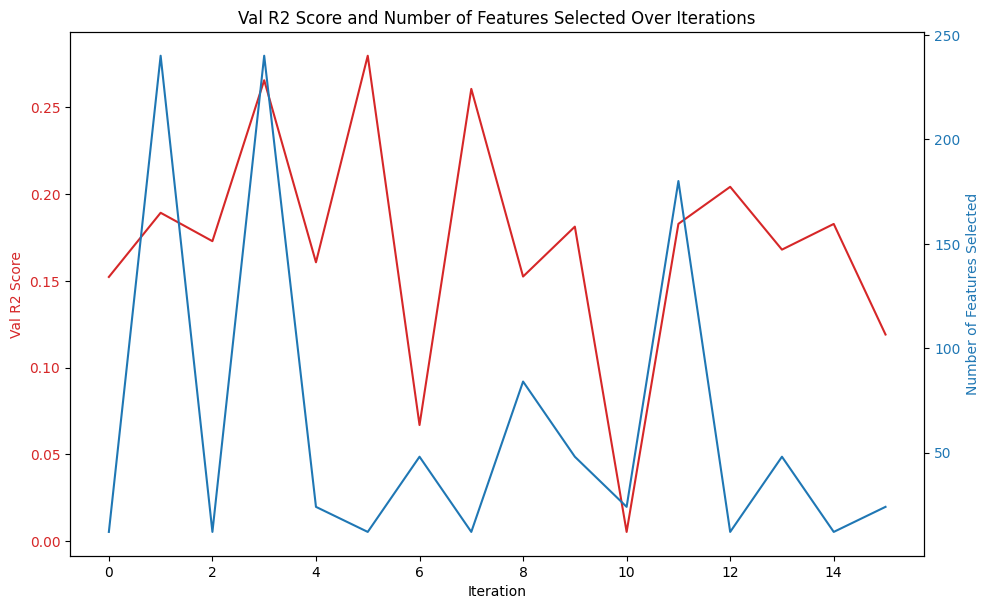

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Val R2 Score', color=color)
ax1.plot(val_r2_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # 初始化一个共享X轴的第二个Y轴
color = 'tab:blue'
ax2.set_ylabel('Number of Features Selected', color=color)  # 我们在第二个Y轴上标记
ax2.plot(feature_selector_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # 为了让布局更紧凑
plt.title('Val R2 Score and Number of Features Selected Over Iterations')
plt.show()

ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (6).

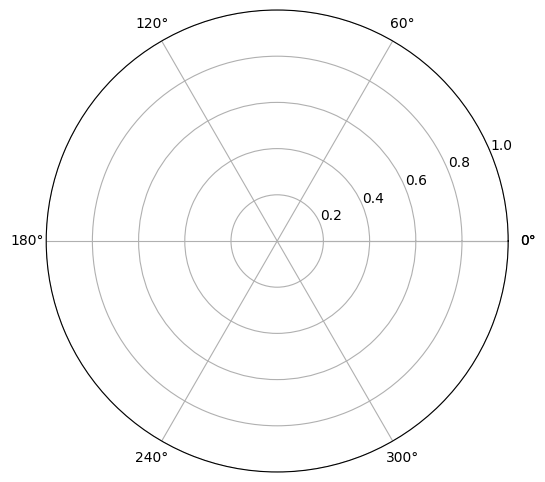

In [70]:
from math import pi

# Number of variables we're plotting.
num_vars = len(plt_list)

# Since we are plotting just one metric ('mse'), we will create the radar chart accordingly.

# Calculate the angle for each category
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]


# The plot is made circular, so we need to "complete the loop" and append the start to the end.
values = plt_list[0]
values += values[:1]
angles += angles[:1]

# Initialise the radar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(angles[:-1], ['mse', 'mae', 'roc', 'cos', 'dst', 'r2'])

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([1, 2, 3, 4, 5], ["1", "2", "3", "4", "5"], color="grey", size=7)
plt.ylim(0, 5)

# Plot data and fill with color
ax.plot(angles, values, linewidth=1, linestyle='solid')
ax.fill(angles, values, 'b', alpha=0.1)

# Add a title
plt.title('Metric Comparison', size=20, color='w', y=1.1)

# Show the plot
plt.show()


In [11]:
n_fold = 20
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=42)




lr = LogisticRegression(solver='liblinear', max_iter=1000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2'],
                  'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                  'solver': ['newton-cg', 'sag', 'lbfgs']
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))



Best score: 0.7971874999999999
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}


In [12]:
# Ramdom Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=Random_Seed)

parameter_grid = {'n_estimators': [100, 200, 300],
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'criterion': ['gini', 'entropy'],
                    'class_weight': ['balanced', 'balanced_subsample', None]
                     }

grid_search = GridSearchCV(rf, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))



e:\Anaconda\envs\LMH\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "e:\Anaconda\envs\LMH\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\Anaconda\envs\LMH\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "e:\Anaconda\envs\LMH\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "e:\Anaconda\envs\LMH\lib\site-packages\sklearn\utils\_p

Best score: 0.76375
Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 200}


In [13]:
lr = LogisticRegression(solver='liblinear', max_iter=10000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'C' : [0.001, 0.01, 0.08, 0.1, 0.15, 1.0, 10.0, 100.0],
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.835625
Best parameters: {'C': 0.15, 'class_weight': None, 'penalty': 'l1'}


In [14]:
# blending the models
model_1 = LogisticRegression(solver='liblinear', class_weight='balanced', penalty='l1', C=0.095)
model_3 = LogisticRegression(solver='liblinear', max_iter=10000, class_weight='balanced', penalty='l2', C=0.08)
model_4 = Lasso(alpha=0.031, tol=0.01, random_state=Random_Seed, selection='random')

models = [model_1, model_3, model_4]

predictions = pd.DataFrame()
for model in models:
    model.fit(X_train, y_train)
    # Check if the model has 'predict_proba' attribute (i.e., it's a classifier)
    if hasattr(model, 'predict_proba'):
        pred = pd.DataFrame(model.predict_proba(test)[:, 1])
    else:
        # For regression models, use the predict method directly
        # Depending on your task, you might need to adjust this part
        pred = pd.DataFrame(model.predict(test))
    predictions = pd.concat([predictions, pred], axis=1)

mean_pred = pd.DataFrame(predictions.mean(axis=1))
mean_pred.index += 250  # Adjusting the index if necessary
mean_pred.columns = ['target']

mean_pred.to_csv('./Submission/Blending.csv', index=True, index_label='id')

In [24]:
train_data = pd.read_csv('./Dataset/train.csv')
test_data = pd.read_csv('./Dataset/test.csv')

# some heuristic settings
rfe_min_features = 12
rfe_step = 15
rfe_cv = 20
sss_n_splits = 16
sss_test_size = 0.35
grid_search_cv = 28
noise_std = 0.01
r2_threshold = 0.213

np.random.seed(42)


# scale using RobustScaler
data = RobustScaler().fit_transform(np.concatenate((X_train, test), axis=0))
X_train = data[:250]
test = data[250:]

# add a bit of noise to train_X to reduce overfitting
X_train += np.random.normal(0, noise_std, X_train.shape)

# define roc_auc_metric robust to only one class in y_pred
def scoring_roc_auc(y, y_pred):
    try:
        return roc_auc_score(y, y_pred)
    except:
        return 0.5

robust_roc_auc = make_scorer(scoring_roc_auc)

# define model and its parameters
lasso_model = Lasso(alpha=0.031, tol=0.01, random_state=42, selection='random')

param_grid = {
            'alpha' : [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031],
            'tol'   : [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017, 0.0018, 0.0019]
        }

# define recursive elimination feature selector
feature_selector = RFECV(lasso_model, min_features_to_select=rfe_min_features, scoring=robust_roc_auc, step=rfe_step, verbose=0, cv=rfe_cv, n_jobs=-1)

print("counter | val_mse  |  val_mae  |  val_roc  |  val_cos  |  val_dist  |  val_r2    | feature_count ")
print("-------------------------------------------------------------------------------------------------")

predictions = pd.DataFrame()
counter = 0
# split training data to build one model on each traing-data-subset
for train_index, val_index in StratifiedShuffleSplit(n_splits=sss_n_splits, test_size=sss_test_size, random_state=42).split(X_train, y_train):
    X, val_X = X_train[train_index], X_train[val_index]
    y, val_y = y_train[train_index], y_train[val_index]

    # get the best features for this data set
    feature_selector.fit(X, y)
    # remove irrelevant features from X, val_X and test
    X_important_features        = feature_selector.transform(X)
    val_X_important_features    = feature_selector.transform(val_X)
    test_important_features     = feature_selector.transform(test)

    # run grid search to find the best Lasso parameters for this subset of training data and subset of features 
    grid_search = GridSearchCV(feature_selector.estimator_, param_grid=param_grid, verbose=0, n_jobs=-1, scoring=robust_roc_auc, cv=20)
    grid_search.fit(X_important_features, y)

    # score our fitted model on validation data
    val_y_pred = grid_search.best_estimator_.predict(val_X_important_features)
    val_mse = mean_squared_error(val_y, val_y_pred)
    val_mae = mean_absolute_error(val_y, val_y_pred)
    val_roc = roc_auc_score(val_y, val_y_pred)
    val_cos = cosine_similarity(val_y.values.reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_dst = euclidean_distances(val_y.values.reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_r2  = r2_score(val_y, val_y_pred)

    # if model did well on validation, save its prediction on test data, using only important features
    # you can use any other metric/metric combination that works for you
    if val_r2 > r2_threshold:
        message = '<-- OK'
        prediction = grid_search.best_estimator_.predict(test_important_features)
        predictions = pd.concat([predictions, pd.DataFrame(prediction)], axis=1)
    else:
        message = '<-- skipping'


    print("{0:2}      | {1:.4f}   |  {2:.4f}   |  {3:.4f}   |  {4:.4f}   |  {5:.4f}    |  {6:.4f}    |  {7:3}         {8}  ".format(counter, val_mse, val_mae, val_roc, val_cos, val_dst, val_r2, feature_selector.n_features_, message))
    
    counter += 1

print("-------------------------------------------------------------------------------------------------")
print("{}/{} models passed validation threshold and will be ensembled.".format(len(predictions.columns), sss_n_splits))

mean_pred = pd.DataFrame(predictions.mean(axis=1))
mean_pred.index += 250
mean_pred.columns = ['target']

mean_pred.to_csv('./Submission/Lasso_REFCV_1.csv', index=True, index_label='id')

mean_pred.head()

counter | val_mse  |  val_mae  |  val_roc  |  val_cos  |  val_dist  |  val_r2    | feature_count 
-------------------------------------------------------------------------------------------------
 0      | 0.1903   |  0.3784   |  0.7667   |  0.8387   |  4.0922    |  0.1776    |  105         <-- skipping  
 1      | 0.1944   |  0.3781   |  0.7746   |  0.8335   |  4.1357    |  0.1601    |   12         <-- skipping  
 2      | 0.2124   |  0.4010   |  0.7165   |  0.8222   |  4.3235    |  0.0820    |  120         <-- skipping  
 3      | 0.2034   |  0.3839   |  0.7171   |  0.8255   |  4.2303    |  0.1212    |  210         <-- skipping  
 4      | 0.1962   |  0.3805   |  0.7388   |  0.8338   |  4.1556    |  0.1520    |   12         <-- skipping  
 5      | 0.1841   |  0.3736   |  0.7706   |  0.8435   |  4.0246    |  0.2046    |  285         <-- skipping  
 6      | 0.1755   |  0.3736   |  0.8103   |  0.8512   |  3.9295    |  0.2417    |  300         <-- OK  
 7      | 0.1904   |  0.3796   | 

,target
250,0.628708
251,0.623007
252,0.529072
253,0.758704
254,0.579716
